# Multimodal Retrieval Augmented Generation With Weaviate
@Author: Zoumana KEITA

## Use Case Workflow  


## Data Collection

### 1. Download audio data from Google

In [ ]:
!pip -qqq install yt-dlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.4/194.4 kB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 40.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 21.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.


In [ ]:
from yt_dlp import YoutubeDL
import os
import re

In [ ]:
class YouTubeAudioDownloader:
    def __init__(self, output_folder):
        self.output_folder = os.path.abspath(output_folder)
        self.audio_files_dict = {}

    def get_safe_filename(self, filename):
        safe_filename = re.sub(r'[^\w\-.]', '_', filename)
        safe_filename = re.sub(r'_+', '_', safe_filename)
        safe_filename = safe_filename[:50].strip('_')
        return safe_filename

    def download_audio(self, video_url):
        try:
            ydl_opts = {
                'format': 'bestaudio/best',
                'postprocessors': [{
                    'key': 'FFmpegExtractAudio',
                    'preferredcodec': 'mp3',
                    'preferredquality': '192',
                }],
                'outtmpl': os.path.join(self.output_folder, '%(title)s.%(ext)s'),
            }

            with YoutubeDL(ydl_opts) as ydl:
                info = ydl.extract_info(video_url, download=True)
                filename = ydl.prepare_filename(info)
                base, ext = os.path.splitext(filename)
                new_file = base + '.mp3'

            print(f"Audio file downloaded: {new_file}")
            self.audio_files_dict[video_url] = new_file
            return new_file
        except Exception as e:
            print(f"Error downloading audio from {video_url}: {str(e)}")
            return None

    def download_multiple_audios(self, video_urls):
        for url in video_urls:
            print(f"Processing video: {url}")
            audio_file = self.download_audio(url)
            if audio_file is None:
                print(f"Failed to download audio from video: {url}")
        return self.audio_files_dict

In [ ]:
downloader = YouTubeAudioDownloader(output_folder="./data")

# List of video URLs
video_urls = ["https://www.youtube.com/watch?v=qP1JKWBBy80",
                "https://www.youtube.com/watch?v=_p58cZIHDG4"]

# Download audios from multiple videos
audio_files = downloader.download_multiple_audios(video_urls)

print("Downloaded audio files:")
for audio_file in audio_files:
    print(audio_file)


Processing video: https://www.youtube.com/watch?v=qP1JKWBBy80
[youtube] Extracting URL: https://www.youtube.com/watch?v=qP1JKWBBy80
[youtube] qP1JKWBBy80: Downloading webpage
[youtube] qP1JKWBBy80: Downloading ios player API JSON
[youtube] qP1JKWBBy80: Downloading player 8eff86d5
[youtube] qP1JKWBBy80: Downloading m3u8 information
[info] qP1JKWBBy80: Downloading 1 format(s): 251
[download] Destination: /content/data/How to Invest with your Conscience： ESG Investing.webm
[download] 100% of    4.32MiB in 00:00:00 at 9.05MiB/s   
[ExtractAudio] Destination: /content/data/How to Invest with your Conscience： ESG Investing.mp3
Deleting original file /content/data/How to Invest with your Conscience： ESG Investing.webm (pass -k to keep)
Audio file downloaded: /content/data/How to Invest with your Conscience： ESG Investing.mp3
Processing video: https://www.youtube.com/watch?v=_p58cZIHDG4
[youtube] Extracting URL: https://www.youtube.com/watch?v=_p58cZIHDG4
[youtube] _p58cZIHDG4: Downloading web

In [ ]:
audio_files

{'https://www.youtube.com/watch?v=qP1JKWBBy80': '/content/data/How to Invest with your Conscience： ESG Investing.mp3',
 'https://www.youtube.com/watch?v=_p58cZIHDG4': "/content/data/ESG investing is 'a complete fraud'： Venture capitalist Chamath Palihapitiya.mp3"}

### 2. Transcriptions Generation With Whisper

In [ ]:
!pip -qqq install openai-whisper

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 798.6/798.6 kB 8.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 59.5 MB/s eta 0:00:00


In [ ]:
import whisper
import torch

In [ ]:
class AudioTranscriber:
    def __init__(self, input_folder):
        self.input_folder = os.path.abspath(os.path.join(os.getcwd(), input_folder))
        self.whisper_model = None
        self.transcriptions_dict = {}

    def transcribe_audio(self, audio_file):
        try:
            if not os.path.exists(audio_file):
                print(f"Audio file not found: {audio_file}")
                return None

            file_size = os.path.getsize(audio_file)
            if file_size == 0:
                print(f"Audio file is empty: {audio_file}")
                return None

            transcription = self.whisper_model.transcribe(audio_file)
            return transcription["text"]
        except Exception as e:
            print(f"Error in transcribe_audio: {str(e)}")
            return None

    def transcribe_all_audios(self, audio_files_dict):
        for url, audio_path in audio_files_dict.items():
            if not audio_path.endswith('.mp3'):
                print(f"Skipping non-mp3 file: {audio_path}")
                continue

            transcription = self.transcribe_audio(audio_path)

            if transcription is not None:
                # Add to transcriptions dictionary
                self.transcriptions_dict[url] = {
                    'url': url,
                    'audio_path': audio_path,
                    'transcription': transcription
                }
            else:
                print(f"Failed to transcribe audio: {audio_path}")

        return self.transcriptions_dict

In [ ]:
# Set the device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load the model
whisper_model = whisper.load_model("medium", device=device)


100%|██████████████████████████████████████| 1.42G/1.42G [00:14<00:00, 104MiB/s]


In [ ]:
# Initialize the AudioTranscriber
transcriber = AudioTranscriber(input_folder=r"./data")

# Initialize your Whisper model
transcriber.whisper_model = whisper_model

# Transcribe all audios in the input folder
transcriptions_dict = transcriber.transcribe_all_audios(audio_files)

for url, data in transcriptions_dict.items():
    print(f"URL: {url}")
    print(f"Audio file: {data['audio_path']}")
    print(f"Transcription: {data['transcription'][:100]}...")  # Print first 100 characters
    print("---")

URL: https://www.youtube.com/watch?v=qP1JKWBBy80
Audio file: /content/data/How to Invest with your Conscience： ESG Investing.mp3
Transcription:  It's your money, why not invest it in something that's truly rooted in your values? Hey there, welc...
---
URL: https://www.youtube.com/watch?v=_p58cZIHDG4
Audio file: /content/data/ESG investing is 'a complete fraud'： Venture capitalist Chamath Palihapitiya.mp3
Transcription:  ESG, real or marketing? It's a complete fraud. Complete fraud. It's so ridiculous. Governance has b...
---


In [ ]:
transcriptions_dict

{'https://www.youtube.com/watch?v=qP1JKWBBy80': {'url': 'https://www.youtube.com/watch?v=qP1JKWBBy80',
  'audio_path': '/content/data/How to Invest with your Conscience： ESG Investing.mp3',
  'transcription': " It's your money, why not invest it in something that's truly rooted in your values? Hey there, welcome back to my channel. It's another day of interviewing John Mollett, my colleague here at Pleasant Wealth. Thanks for being here again, John. Thanks, Liz. My pleasure. It's great to be able to have some of these conversations about what we talk about here in the office, here for you, so you can make some good decisions with your investments. So in today's video, we're going to be talking about ESG investing, and you may not have heard that term, but stay tuned because that's what we're going to talk about. Before we get into that, don't forget to subscribe to this channel for regular, pleasant financial content. All right, John, let's talk about ESG investing. What does ESG even 

In [ ]:
# Get the first key-value pair in the dictionary
first_item = next(iter(transcriptions_dict.items()))

# Extract the transcription from the first item
first_transcription = first_item[1]['transcription']

first_transcription

" It's your money, why not invest it in something that's truly rooted in your values? Hey there, welcome back to my channel. It's another day of interviewing John Mollett, my colleague here at Pleasant Wealth. Thanks for being here again, John. Thanks, Liz. My pleasure. It's great to be able to have some of these conversations about what we talk about here in the office, here for you, so you can make some good decisions with your investments. So in today's video, we're going to be talking about ESG investing, and you may not have heard that term, but stay tuned because that's what we're going to talk about. Before we get into that, don't forget to subscribe to this channel for regular, pleasant financial content. All right, John, let's talk about ESG investing. What does ESG even stand for? So ESG stands for environmental social governance. Environmental is pretty self-explanatory, anything to do with being a good steward of the environment, natural resources, sustainability, and socia

In [ ]:
import json

audio_data = [
    {
        "url": value["url"],
        "audio_path": value["audio_path"],
        "transcription": value["transcription"]
    }
    for value in transcriptions_dict.values()
]

# Print the result
print(json.dumps(audio_data, indent=2))

[
  {
    "url": "https://www.youtube.com/watch?v=qP1JKWBBy80",
    "audio_path": "/content/data/How to Invest with your Conscience\uff1a ESG Investing.mp3",
    "transcription": " It's your money, why not invest it in something that's truly rooted in your values? Hey there, welcome back to my channel. It's another day of interviewing John Mollett, my colleague here at Pleasant Wealth. Thanks for being here again, John. Thanks, Liz. My pleasure. It's great to be able to have some of these conversations about what we talk about here in the office, here for you, so you can make some good decisions with your investments. So in today's video, we're going to be talking about ESG investing, and you may not have heard that term, but stay tuned because that's what we're going to talk about. Before we get into that, don't forget to subscribe to this channel for regular, pleasant financial content. All right, John, let's talk about ESG investing. What does ESG even stand for? So ESG stands for e

### 3. PDF Documents Parsing  

From a PDF, extract text, images, tables, and summarize everything to the following.
- text: --remain--> text  
- images: --get text --> summarize

Information required for a given report document.

- For text information:
    - source_document: path to the ESG report
    - document_type: TEXT
    - raw_text: textual information
    - embedding: the embedding of the text

- For images:
    - source_document: path to the ESG report
    - document_type: IMAGE
    - page_number: INTEGER
    - raw_text: textual description
    - embedding: the embedding of the textual description

- For tables:
    - source_document: path to the ESG report
    - document_type: TABLE
    - raw_text: textual description
    - embedding: the embedding of the textual description


Side note:
- If you have multiple `pip` commands to run from a Jupyter notebook, it is better to run them as a bash command using the `%%bash` keyword.

- Also use `-qqq` so that the installation in a verbose mode.


In [ ]:
%%bash

pip -qqq install pdfminer.six
pip -qqq install pillow-heif==0.3.2
pip -qqq install matplotlib
pip -qqq install unstructured-inference
pip -qqq install unstructured-pytesseract
pip -qqq install tesseract-ocr
pip -qqq install unstructured

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.4/56.4 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.2/19.2 MB 50.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 82.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 113.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 95.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 99.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.0/58.0 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

  ERROR: Failed building wheel for tesseract-ocr
ERROR: Could not build wheels for tesseract-ocr, which is required to install pyproject.toml-based projects


`Unstructured` module depends on tesseract, and using the following statements performs a successful installation.

In [ ]:
%%bash
apt install tesseract-ocr
apt install libtesseract-dev

Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 45 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 2s (2,683 kB/s)
Selecting previously unselected package tesseract-ocr-eng.
(Reading database ... 123586 files and directories currently installed.)
Preparing to unpack .../tesseract-ocr-eng_1%3a4.00~gi

In [ ]:
from unstructured.partition.pdf import partition_pdf

In [ ]:
esg_report_path = "./data/Global_ESG_Q1_2024_Flows_Report.pdf"

`Poppler` module is also used as backend for PDF processing.

In [ ]:
%%bash
sudo apt-get update
apt-get install poppler-utils

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Ign:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy Release [5,713 B]
Hit:6 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy Release.gpg [793 B]
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:9 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,050 kB]
Hit:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,547 kB]
Hit:12 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:13 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,128 kB]
Get:14 

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


In [ ]:
esg_report_raw_data =partition_pdf(
    filename=esg_report_path,
    strategy="hi_res",
    extract_images_in_pdf=True,
    extract_image_block_to_payload=False,
    extract_image_block_output_dir="./data/images/"
    )

yolox_l0.05.onnx:   0%|          | 0.00/217M [00:00<?, ?B/s]

In [ ]:
esg_report_raw_data

The above result shows all the element types in that PDF file. For instance:  
- `.elements.Image` components represent images in the document.  
- `.elements.NarrativeText` components represent raw text data in the document.    
-  `.elements.Table` components represent tables data in the document.  

#### 1. Extract Textual Component

In [ ]:
from unstructured.documents.elements import NarrativeText

In [ ]:
def extract_text_with_metadata(esg_report, source_document):

    text_data = []
    paragraph_counters = {}

    for element in esg_report:
        if isinstance(element, NarrativeText):
            page_number = element.metadata.page_number

            if page_number not in paragraph_counters:
                paragraph_counters[page_number] = 1
            else:
                paragraph_counters[page_number] += 1

            paragraph_number = paragraph_counters[page_number]

            text_content = element.text
            text_data.append({
                "source_document": source_document,
                "page_number": page_number,
                "paragraph_number": paragraph_number,
                "text": text_content
            })

    return text_data

In [ ]:
extracted_data = extract_text_with_metadata(esg_report_raw_data, esg_report_path)


In [ ]:
extracted_data

[{'source_document': './data/Global_ESG_Q1_2024_Flows_Report.pdf',
  'page_number': 1,
  'paragraph_number': 1,
  'text': 'April 25, 2024'},
 {'source_document': './data/Global_ESG_Q1_2024_Flows_Report.pdf',
  'page_number': 1,
  'paragraph_number': 2,
  'text': '40 Appendix—Defining the Global Sustainable Fund Universe'},
 {'source_document': './data/Global_ESG_Q1_2024_Flows_Report.pdf',
  'page_number': 1,
  'paragraph_number': 3,
  'text': 'Corrections issued April 29, 2024.'},
 {'source_document': './data/Global_ESG_Q1_2024_Flows_Report.pdf',
  'page_number': 1,
  'paragraph_number': 4,
  'text': 'The global sustainable fund universe encompasses open-end funds and exchange-traded funds that, by prospectus or other regulatory filings, claim to focus on sustainability; impact; or environmental, social, and governance factors.” (See the Appendix for more details on how we define the global sustainable fund universe.)'},
 {'source_document': './data/Global_ESG_Q1_2024_Flows_Report.pdf'

#### 2. Extract Image Components

In [ ]:
from unstructured.documents.elements import Image

In [ ]:
def extract_image_metadata(esg_report, source_document):
    image_data = []

    for element in esg_report:
        if isinstance(element, Image):
            page_number = element.metadata.page_number
            image_path = element.metadata.image_path if hasattr(element.metadata, 'image_path') else None

            image_data.append({
                "source_document": source_document,
                "page_number": page_number,
                "image_path": image_path
            })

    return image_data

In [ ]:
extracted_image_data = extract_image_metadata(esg_report_raw_data, esg_report_path)

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import math

In [ ]:
def display_images_from_metadata(extracted_image_data, images_per_row=4):
    valid_images = [img for img in extracted_image_data if img['image_path']]
    if not valid_images:
        print("No valid image data available.")
        return

    num_images = len(valid_images)
    num_rows = math.ceil(num_images / images_per_row)

    fig, axes = plt.subplots(num_rows, images_per_row, figsize=(20, 5*num_rows))
    axes = axes.flatten() if num_rows > 1 else [axes]

    for ax, img_data in zip(axes, valid_images):
        try:
            img = Image.open(img_data['image_path'])
            ax.imshow(img)
            ax.axis('off')
            ax.set_title(f"Page {img_data['page_number']}", fontsize=10)
        except Exception as e:
            print(f"Error loading image {img_data['image_path']}: {str(e)}")
            ax.text(0.5, 0.5, f"Error loading image\n{str(e)}", ha='center', va='center')
            ax.axis('off')

    for ax in axes[num_images:]:
        fig.delaxes(ax)

    plt.tight_layout()
    plt.show()

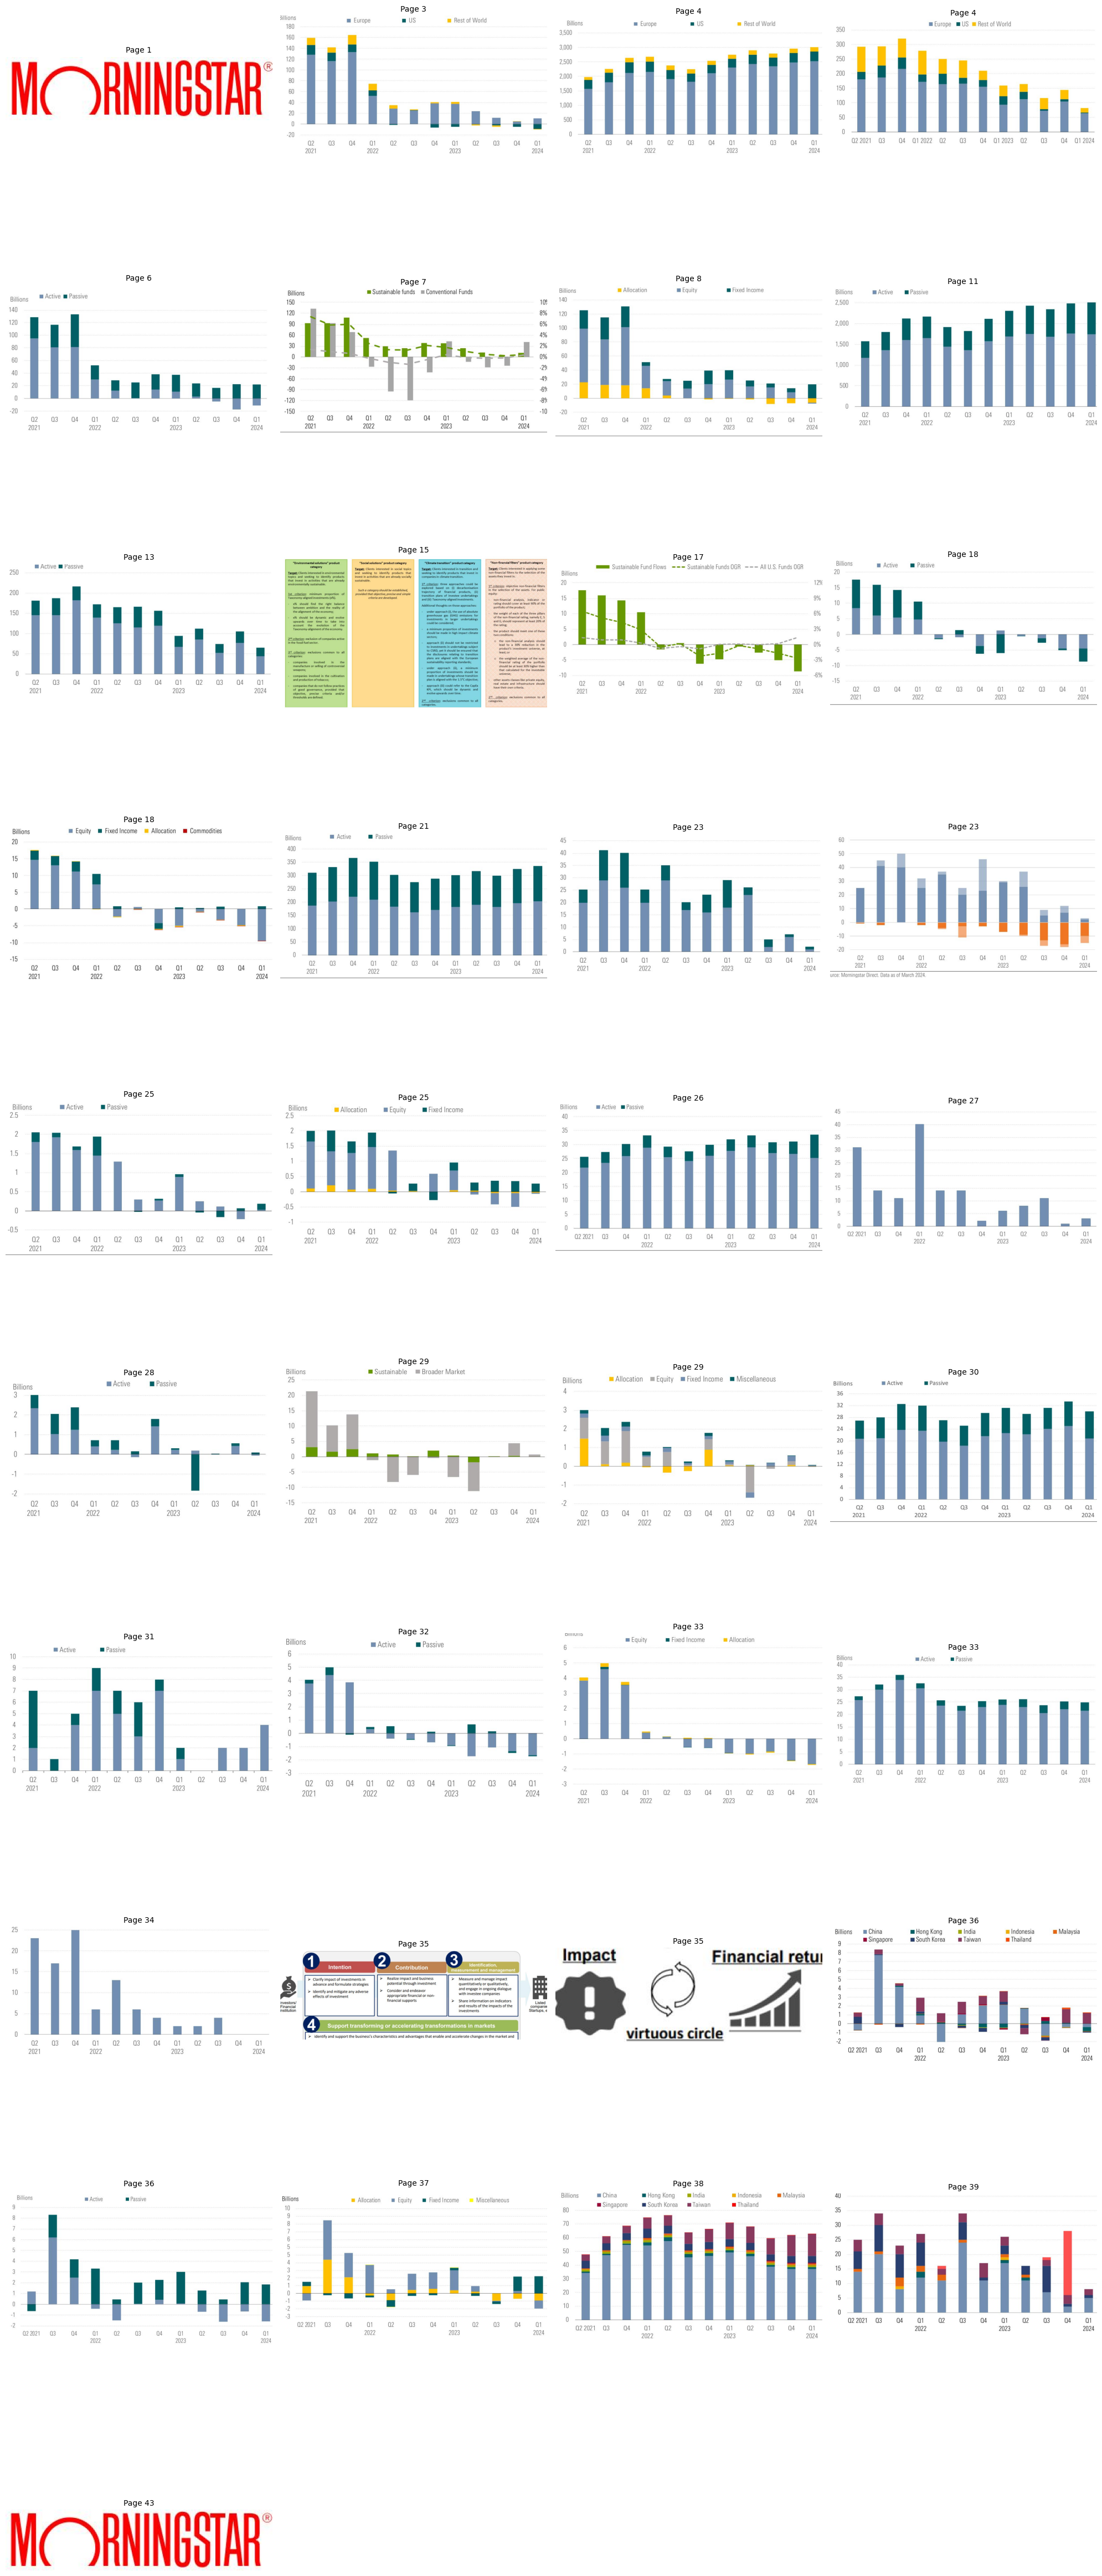

In [ ]:
display_images_from_metadata(extracted_image_data)

#### 3. Extract Table Components

In [ ]:
from unstructured.documents.elements import Table

In [ ]:
def extract_table_metadata(esg_report, source_document):
    table_data = []

    for element in esg_report:
        if isinstance(element, Table):
            page_number = element.metadata.page_number

            # Extract table content as a string
            table_content = str(element)

            table_data.append({
                "source_document": source_document,
                "page_number": page_number,
                "table_content": table_content
            })

    return table_data

In [ ]:
extracted_table_data = extract_table_metadata(esg_report_raw_data, esg_report_path)

### 4. Image and Table summarization   
Images and Tables will be described in a way that make them undertandable in a few sentences.

For both image and table, we get a description first using the corresponding prompts.

#### 1. Table summarization

In [ ]:
%%bash

pip -qqq install langchain-core
pip -qqq install langchain-openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 372.0/372.0 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.7/134.7 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 328.5/328.5 kB 6.6 MB/s eta 0:00:00


In [ ]:
tables_summarizer_prompt = """
As an ESG analyst for emerging markets investments, provide a concise and exact summary of the table contents.
Focus on key ESG metrics (Environmental, Social, Governance) and their relevance to emerging markets.
Highlight significant trends, comparisons, or outliers in the data. Identify any potential impacts on investment strategies or risk assessments.
Avoid bullet points; instead, deliver a coherent, factual summary that captures the essence of the table for ESG investment decision-making.

Table: {table_content}

Limit your summary to 3-4 sentences, ensuring it's precise and informative for ESG analysis in emerging markets."""

In [ ]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

In [ ]:
from google.colab import userdata
#userdata.get('OPENAI_API_TOKEN')

In [ ]:
OPENAI_API_TOKEN = userdata.get('OPENAI_API_TOKEN')
model_ID = "gpt-4o"
os.environ["OPENAI_API_KEY"] = OPENAI_API_TOKEN

In [ ]:
description_model = ChatOpenAI(model=model_ID)

In [ ]:
def extract_table_metadata_with_summary(esg_report,
                                        source_document,
                                        tables_summarizer_prompt):

    table_data = []
    prompt = ChatPromptTemplate.from_template(tables_summarizer_prompt)

    for element in esg_report:
        if isinstance(element, Table):
            page_number = element.metadata.page_number

            # Extract table content as a string
            table_content = str(element)

            # Generate summary using the OpenAI model
            messages = prompt.format_messages(table_content=table_content)
            description = description_model.predict_messages(messages).content

            table_data.append({
                "source_document": source_document,
                "page_number": page_number,
                "table_content": table_content,
                "description": description
            })

    return table_data

In [ ]:
extracted_table_data_with_summary = extract_table_metadata_with_summary(esg_report_raw_data,
                                                                        esg_report_path,
                                                                        tables_summarizer_prompt)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The method `BaseChatModel.predict_messages` was deprecated in langchain-core 0.1.7 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


In [ ]:
extracted_table_data_with_summary

[{'source_document': './data/Global_ESG_Q1_2024_Flows_Report.pdf',
  'page_number': 2,
  'table_content': 'Q1 2024 Flows Assets Funds Region USD Billion USD Billion _% Total # —_ %Total Europe 10.9 2,513 84 5,581 United States 88 335 1 630 Asia ex-Japan 0.2 63 2 606 Australia/New Zealand 0.0 30 | 261 Japan 17 25 | 233 Canada 0.2 34 1 332 Total 0.9 2,999 7,643',
  'description': 'The table reveals that emerging markets, specifically Asia ex-Japan, show modest ESG investment inflows at $0.2 billion, representing 2% of total assets, which underscores a growing but still limited commitment to ESG in these regions. Europe dominates with $10.9 billion in flows and 84% of total assets, highlighting a mature and substantial ESG market. The United States, despite higher absolute flows at $88 billion, reflects only 1% of total assets, suggesting a broader but less concentrated ESG engagement. These trends indicate that while emerging markets are gradually increasing ESG investments, Europe remai

In [ ]:
# Get the first key-value pair in the dictionary
first_table_details = extracted_table_data_with_summary[0]

# Extract the transcription from the first item
first_description = first_table_details

first_description

{'source_document': './data/Global_ESG_Q1_2024_Flows_Report.pdf',
 'page_number': 2,
 'table_content': 'Q1 2024 Flows Assets Funds Region USD Billion USD Billion _% Total # —_ %Total Europe 10.9 2,513 84 5,581 United States 88 335 1 630 Asia ex-Japan 0.2 63 2 606 Australia/New Zealand 0.0 30 | 261 Japan 17 25 | 233 Canada 0.2 34 1 332 Total 0.9 2,999 7,643',
 'description': 'The table reveals that emerging markets, specifically Asia ex-Japan, show modest ESG investment inflows at $0.2 billion, representing 2% of total assets, which underscores a growing but still limited commitment to ESG in these regions. Europe dominates with $10.9 billion in flows and 84% of total assets, highlighting a mature and substantial ESG market. The United States, despite higher absolute flows at $88 billion, reflects only 1% of total assets, suggesting a broader but less concentrated ESG engagement. These trends indicate that while emerging markets are gradually increasing ESG investments, Europe remains t

In [ ]:
first_description['description']

'The table reveals that emerging markets, specifically Asia ex-Japan, show modest ESG investment inflows at $0.2 billion, representing 2% of total assets, which underscores a growing but still limited commitment to ESG in these regions. Europe dominates with $10.9 billion in flows and 84% of total assets, highlighting a mature and substantial ESG market. The United States, despite higher absolute flows at $88 billion, reflects only 1% of total assets, suggesting a broader but less concentrated ESG engagement. These trends indicate that while emerging markets are gradually increasing ESG investments, Europe remains the benchmark, and this disparity might influence risk assessments and strategic allocation towards more established ESG markets for stability and returns.'

#### 2. Image summarization

In [ ]:
from PIL import Image as PILImage
import base64

In [ ]:
images_summarizer_prompt = """
As an ESG analyst for emerging markets investments, please provide a clear interpretation of data or information that see describe from the image.
Focus on ESG-relevant content (Environmental, Social, Governance) and any emerging market context. Describe the type of visual (e.g., chart, photograph, infographic) and its key elements.
Highlight significant data points or trends that are relevant to investment analysis. Avoid bullet points; instead, deliver a coherent, factual summary that captures the essence of the image for ESG investment decision-making.

Image: {image_element}

Limit your description to 3-4 sentences, ensuring it's precise and informative for ESG analysis."""

In [ ]:
def extract_image_metadata_with_summary(esg_report_raw_data,
                                        esg_report_path,
                                        images_summarizer_prompt):

    image_data = []

    # Create ChatPromptTemplate instance
    prompt = ChatPromptTemplate.from_template(images_summarizer_prompt)

    # Create ChatOpenAI instance
    description_model = ChatOpenAI(model=model_ID)

    for element in esg_report_raw_data:
        if "Image" in str(type(element)):
            page_number = element.metadata.page_number if hasattr(element.metadata, 'page_number') else None
            image_path = element.metadata.image_path if hasattr(element.metadata, 'image_path') else None

            if image_path and os.path.exists(image_path):
                # Generate description using the OpenAI model
                messages = prompt.format_messages(image_element=image_path)
                description = description_model.predict_messages(messages).content

                # Read the image file and encode it to base64
                with open(image_path, "rb") as image_file:
                    encoded_string = base64.b64encode(image_file.read()).decode('utf-8')

                image_data.append({
                    "source_document": esg_report_path,
                    "page_number": page_number,
                    "image_path": image_path,
                    "description": description,
                    "base64_encoding": encoded_string
                })
            else:
                print(f"Warning: Image file not found or path not available for image on page {page_number}")

    return image_data

In [ ]:
extracted_image_data = extract_image_metadata_with_summary(esg_report_raw_data,
                                                           esg_report_path,
                                                           images_summarizer_prompt)

In [ ]:
extracted_image_data

[{'source_document': './data/Global_ESG_Q1_2024_Flows_Report.pdf',
  'page_number': 1,
  'image_path': './data/images/figure-1-1.jpg',
  'description': 'Unfortunately, I am unable to view images directly. However, I can still help you interpret the image effectively if you provide a detailed description of its contents. Describe the type of visual (e.g., chart, photograph, infographic), any text or labels included, and the key elements or data points presented. This will allow me to offer a precise and informative summary for ESG investment analysis in emerging markets.',
  'base64_encoding': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCABcAYUDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFV

In [ ]:
# Get the first key-value pair in the dictionary
sixth_image_details = extracted_image_data[5]

sixth_image_details

{'source_document': './data/Global_ESG_Q1_2024_Flows_Report.pdf',
 'page_number': 7,
 'image_path': './data/images/figure-7-6.jpg',
 'description': 'The image described appears to be an infographic illustrating ESG performance metrics for various emerging market countries. It likely includes visual elements such as bar charts or graphs to depict environmental, social, and governance scores. Key elements may include country-specific data points like carbon emissions, social equity indicators, and governance quality ratings. Significant trends, such as high carbon emissions in rapidly industrializing nations or improving governance scores in countries implementing reforms, are crucial for investment decisions, as they highlight both risks and opportunities within these markets. Such insights are essential for tailoring investment strategies that align with sustainable and responsible investing principles in emerging economies.',
 'base64_encoding': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBg

In [ ]:
sixth_image_details['description']

'The image described appears to be an infographic illustrating ESG performance metrics for various emerging market countries. It likely includes visual elements such as bar charts or graphs to depict environmental, social, and governance scores. Key elements may include country-specific data points like carbon emissions, social equity indicators, and governance quality ratings. Significant trends, such as high carbon emissions in rapidly industrializing nations or improving governance scores in countries implementing reforms, are crucial for investment decisions, as they highlight both risks and opportunities within these markets. Such insights are essential for tailoring investment strategies that align with sustainable and responsible investing principles in emerging economies.'

## Data Upload

### 0. Connect to the Weaviate instance

In [ ]:
!pip -qqq install weaviate-client

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.7/325.7 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.8/223.8 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.3/309.3 kB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 39.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires protobuf<5,>=3.20, but you have protobuf 5.27.2 which is incompatible.
google-ai-generativelanguage 0.6.4 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 5.27.2 which is incompatible.
google-api-core 2.16.2 requires protobuf!=3.20.

In [ ]:
import weaviate

In [ ]:
# Set these environment variables
URL = userdata.get('WCS_URL')
APIKEY = userdata.get('WCS_API_KEY')

In [ ]:
URL

'https://qktqfxqqcynsbpg7ffscw.c0.us-east1.gcp.weaviate.cloud'

In [ ]:
# Connect to a WCS instance
client = weaviate.connect_to_wcs(
    cluster_url=URL,
    auth_credentials=weaviate.auth.AuthApiKey(APIKEY),
    headers = {
        "X-OpenAI-Api-Key": OPENAI_API_TOKEN
    }
)

In [ ]:
client

### 1. Set Up Weaviate Vector Database

### 2. Create Multimodal ESG Collection

In [ ]:
import weaviate.classes.config as wc

properties = [
    wc.Property(name="source_document", data_type=wc.DataType.TEXT, skip_vectorization=True),
    wc.Property(name="page_number", data_type=wc.DataType.INT, skip_vectorization=True),
    wc.Property(name="paragraph_number", data_type=wc.DataType.INT, skip_vectorization=True),
    wc.Property(name="text", data_type=wc.DataType.TEXT),
    wc.Property(name="image_path", data_type=wc.DataType.TEXT, skip_vectorization=True),
    wc.Property(name="description", data_type=wc.DataType.TEXT),
    wc.Property(name="base64_encoding", data_type=wc.DataType.BLOB, skip_vectorization=True),
    wc.Property(name="table_content", data_type=wc.DataType.TEXT),
    wc.Property(name="url", data_type=wc.DataType.TEXT, skip_vectorization=True),
    wc.Property(name="audio_path", data_type=wc.DataType.TEXT, skip_vectorization=True),
    wc.Property(name="transcription", data_type=wc.DataType.TEXT),
    wc.Property(name="content_type", data_type=wc.DataType.TEXT, skip_vectorization=True),
]

In [ ]:
client.collections.create(
    name="RAGESGDocuments",
    properties=properties,
    vectorizer_config=None
)

### 3. Data Ingestion
#### Helper functions

In [ ]:
# Initialize OpenAI client
from weaviate.util import generate_uuid5
from tqdm import tqdm
from openai import OpenAI
openai_client = OpenAI()

In [ ]:
# Function to get embeddings
def get_embedding(text):
    response = openai_client.embeddings.create(
        input=text,
        model="text-embedding-3-large"
    )
    return response.data[0].embedding

# Ingestion functions
def ingest_audio_data(collection, audio_data):
    with collection.batch.dynamic() as batch:
        for audio in tqdm(audio_data, desc="Ingesting audio data"):
            vector = get_embedding(audio['transcription'])
            audio_obj = {
                "url": audio['url'],
                "audio_path": audio['audio_path'],
                "transcription": audio['transcription'],
                "content_type": "audio"
            }
            batch.add_object(
                properties=audio_obj,
                uuid=generate_uuid5(audio['url']),
                vector=vector
            )

def ingest_text_data(collection, text_data):
    with collection.batch.dynamic() as batch:
        for text in tqdm(text_data, desc="Ingesting text data"):
            vector = get_embedding(text['text'])
            text_obj = {
                "source_document": text['source_document'],
                "page_number": text['page_number'],
                "paragraph_number": text['paragraph_number'],
                "text": text['text'],
                "content_type": "text"
            }
            batch.add_object(
                properties=text_obj,
                uuid=generate_uuid5(f"{text['source_document']}_{text['page_number']}_{text['paragraph_number']}"),
                vector=vector
            )

def ingest_image_data(collection, image_data):
    with collection.batch.dynamic() as batch:
        for image in tqdm(image_data, desc="Ingesting image data"):
            vector = get_embedding(image['description'])
            image_obj = {
                "source_document": image['source_document'],
                "page_number": image['page_number'],
                "image_path": image['image_path'],
                "description": image['description'],
                "base64_encoding": image['base64_encoding'],
                "content_type": "image"
            }
            batch.add_object(
                properties=image_obj,
                uuid=generate_uuid5(f"{image['source_document']}_{image['page_number']}_{image['image_path']}"),
                vector=vector
            )

def ingest_table_data(collection, table_data):
    with collection.batch.dynamic() as batch:
        for table in tqdm(table_data, desc="Ingesting table data"):
            vector = get_embedding(table['description'])
            table_obj = {
                "source_document": table['source_document'],
                "page_number": table['page_number'],
                "table_content": table['table_content'],
                "description": table['description'],
                "content_type": "table"
            }
            batch.add_object(
                properties=table_obj,
                uuid=generate_uuid5(f"{table['source_document']}_{table['page_number']}"),
                vector=vector
            )

def ingest_all_data(collection_name, audio_data, text_data, image_data, table_data):

    collection = client.collections.get(collection_name)

    ingest_audio_data(collection, audio_data)
    ingest_text_data(collection, text_data)
    ingest_image_data(collection, image_data)
    ingest_table_data(collection, table_data)

    if len(collection.batch.failed_objects) > 0:
        print(f"Failed to import {len(collection.batch.failed_objects)} objects")
    else:
        print("All objects imported successfully")

#### Start data ingestion

In [ ]:
ingest_all_data(collection_name="RAGESGDocuments",
                audio_data=audio_data,
                text_data=extracted_data,
                image_data=extracted_image_data,
                table_data=extracted_table_data_with_summary
            )

Ingesting table data: 100%|██████████| 13/13 [00:03<00:00,  4.07it/s]

All objects imported successfully


Now let's have a look at the first object in the collection.

In [ ]:
collection = client.collections.get("RAGESGDocuments")

In [ ]:
# Use next() with the iterator to get only the first item
try:
    first_item = next(collection.iterator(include_vector=True))
    print(first_item.properties)
    print(first_item.vector)
except StopIteration:
    print("The collection is empty.")

{'content_type': 'text', 'transcription': None, 'text': 'Exhibit 13 US Sustainable Fund Flows (USD Billion)', 'table_content': None, 'source_document': './data/Global_ESG_Q1_2024_Flows_Report.pdf', 'image_path': None, 'audio_path': None, 'paragraph_number': 1, 'page_number': 18, 'description': None, 'url': None}
{'default': [-0.0134049654006958, 0.03474212437868118, -0.011565936729311943, 0.00543953524902463, -0.007865723222494125, -0.03864175081253052, -0.026381561532616615, 0.05320626497268677, -0.03571702912449837, 0.026263391599059105, -0.013493592850863934, 0.011034169234335423, 0.024609005078673363, -0.050370171666145325, -0.026706531643867493, 0.002348638605326414, 0.008131606504321098, -0.03110838122665882, -0.04948389157652855, 0.023117102682590485, -0.0015842231223359704, -0.011388680897653103, -0.05651503801345825, 0.015746217221021652, 0.007969122380018234, 0.008441803976893425, 0.013249865733087063, 0.036396510899066925, -0.0031389035284519196, 0.029631249606609344, 0.0162

### 3. Vector database query for most relevant data

In [ ]:
import weaviate.classes.query as wq

In [ ]:

def search_multimodal(query: str, limit: int = 3):
    query_vector = get_embedding(query)

    esg_documents = client.collections.get("RAGESGDocuments")

    response = esg_documents.query.near_vector(
        near_vector=query_vector,
        limit=limit,
        return_metadata=wq.MetadataQuery(distance=True),
        return_properties=[
            "content_type", "url", "audio_path", "transcription",
            "source_document", "page_number", "paragraph_number", "text",
            "image_path", "description", "table_content"
        ]
    )

    return response.objects

In [ ]:
def search_and_print_results(query, limit=3):

    search_results = search_multimodal(query, limit)

    print(f"Search Results for query: '{query}'")
    for item in search_results:
        print(f"Type: {item.properties['content_type']}")
        if item.properties['content_type'] == 'audio':
            print(f"URL: {item.properties['url']}")
            print(f"Transcription: {item.properties['transcription'][:100]}...")
        elif item.properties['content_type'] == 'text':
            print(f"Source: {item.properties['source_document']}, Page: {item.properties['page_number']}")
            print(f"Paragraph {item.properties['paragraph_number']}")
            print(f"Text: {item.properties['text'][:100]}...")
        elif item.properties['content_type'] == 'image':
            print(f"Source: {item.properties['source_document']}, Page: {item.properties['page_number']}")
            print(f"Description: {item.properties['description']}")
        elif item.properties['content_type'] == 'table':
            print(f"Source: {item.properties['source_document']}, Page: {item.properties['page_number']}")
            print(f"Description: {item.properties['description']}")
        print(f"Distance to query: {item.metadata.distance:.3f}")
        print("---")

In [ ]:
query = "What are the main environmental challenges in renewable energy?"
search_and_print_results(query)

Search Results for query: 'What are the main environmental challenges in renewable energy?'
Type: image
Source: ./data/Global_ESG_Q1_2024_Flows_Report.pdf, Page: 30
Description: The image appears to be a bar chart illustrating the percentage of renewable energy adoption across various emerging market countries. The chart highlights significant disparities in renewable energy usage, with some countries like Brazil and India showing higher percentages compared to others like South Africa and Indonesia. This data is crucial for ESG investment analysis as it underscores the varying levels of commitment to environmental sustainability among these nations. Moreover, the trend suggests that countries with higher renewable energy adoption may present more favorable long-term investment opportunities, given the global shift towards sustainable energy sources.
Distance to query: 0.597
---
Type: image
Source: ./data/Global_ESG_Q1_2024_Flows_Report.pdf, Page: 35
Description: As an ESG analyst, the

### 3. Multimodal RAG for ESG

In [ ]:
def generate_response(query: str, context: str) -> str:
    prompt = f"""
    You are an AI assistant specializing in ESG (Environmental, Social, and Governance) analysis for emerging markets.
    Use the following pieces of information to answer the user's question.
    If you cannot answer the question based on the provided information, say that you don't have enough information to answer accurately.

    Context:
    {context}

    User Question: {query}

    Please provide a detailed and accurate answer based on the given context:
    """

    response = openai_client.chat.completions.create(
        model="gpt-4-1106-preview",
        messages=[
            {"role": "system", "content": "You are an expert ESG analyst for emerging markets."},
            {"role": "user", "content": prompt}
        ],
        temperature=0
    )

    return response.choices[0].message.content

In [ ]:
def esg_analysis(user_query: str):

    # Step 1: Retrieve relevant information
    search_results = search_multimodal(user_query)

    # Step 2: Prepare context for RAG
    context = ""
    for item in search_results:
        if item.properties['content_type'] == 'audio':
            context += f"Audio Transcription from {item.properties['url']}: {item.properties['transcription']}\n\n"
        elif item.properties['content_type'] == 'text':
            context += f"Text from {item.properties['source_document']} (Page {item.properties['page_number']}, Paragraph {item.properties['paragraph_number']}): {item.properties['text']}\n\n"
        elif item.properties['content_type'] == 'image':
            context += f"Image Description from {item.properties['source_document']} (Page {item.properties['page_number']}, Path: {item.properties['image_path']}): {item.properties['description']}\n\n"
        elif item.properties['content_type'] == 'table':
            context += f"Table Description from {item.properties['source_document']} (Page {item.properties['page_number']}): {item.properties['description']}\n\n"

    # Step 3: Generate response using RAG
    response = generate_response(user_query, context)

    # Step 4: Format and return the final output
    sources = []
    for item in search_results:
        source = {
            "type": item.properties["content_type"],
            "distance": item.metadata.distance
        }
        if item.properties["content_type"] == 'text':
            source.update({
                "document": item.properties["source_document"],
                "page": item.properties["page_number"],
                "paragraph": item.properties["paragraph_number"]
            })
        elif item.properties["content_type"] == 'image':
            source.update({
                "document": item.properties["source_document"],
                "page": item.properties["page_number"],
                "image_path": item.properties["image_path"]
            })
        elif item.properties["content_type"] == 'table':
            source.update({
                "document": item.properties["source_document"],
                "page": item.properties["page_number"]
            })
        elif item.properties["content_type"] == 'audio':
            source.update({
                "url": item.properties["url"]
            })
        sources.append(source)

    # Sort sources by distance (ascending order)
    sources.sort(key=lambda x: x['distance'])

    final_output = {
        "user_query": user_query,
        "ai_response": response,
        "sources": sources
    }

    return final_output

In [ ]:
!pip -qqq install textwrap3

In [ ]:
import textwrap

def wrap_text(text, width=120):

    wrapped_text = textwrap.fill(text, width=width)

    return wrapped_text

In [ ]:
def analyze_and_print_esg_results(user_question):
    result = esg_analysis(user_question)

    print("User Query:", result["user_query"])
    print("\nAI Response:", wrap_text(result["ai_response"]))
    print("\nSources (sorted by relevance):")
    for source in result["sources"]:
        print(f"- Type: {source['type']}, Distance: {source['distance']:.3f}")
        if source['type'] == 'text':
            print(f"  Document: {source['document']}, Page: {source['page']}, Paragraph: {source['paragraph']}")
        elif source['type'] == 'image':
            print(f"  Document: {source['document']}, Page: {source['page']}, Image Path: {source['image_path']}")
        elif source['type'] == 'table':
            print(f"  Document: {source['document']}, Page: {source['page']}")
        elif source['type'] == 'audio':
            print(f"  URL: {source['url']}")
        print("---")

In [ ]:
user_question = "Is ESG investment a fraud?"
analyze_and_print_esg_results(user_question)

User Query: Is ESG investment a fraud?

AI Response: Based on the provided context, it is not accurate to categorically state that ESG investment is a fraud. The term
"fraud" implies intentional deception for personal or financial gain, which is a strong accusation that requires
specific evidence to support such a claim. The audio transcription from the YouTube video presents a critical opinion
that questions the effectiveness and sincerity of ESG initiatives, suggesting that some companies may use ESG as a
marketing tool or for financial advantages, such as borrowing at negative rates from the European Central Bank (ECB).
However, the text from the Global ESG Q1 2024 Flows Report provides a more nuanced view. It acknowledges that investor
appetite for ESG and sustainable funds in Europe has been weak by historical standards, which could be due to a
challenging macroenvironment, including high interest rates, inflation, and fears of recession. Additionally, it notes
that some investors

The distance metric in Weaviate's near_vector function is used to measure the similarity between vectors in the vector space. It's important to understand that in this context, "distance" is inversely related to similarity. Here's a breakdown:

- Low distance:

  - Indicates high similarity between vectors
  - Means the vectors are close to each other in the vector space
  - Represents objects that are more semantically similar or relevant to the query vector


- High distance:

  - Indicates low similarity between vectors
  - Means the vectors are far apart in the vector space
  - Represents objects that are less semantically similar or relevant to the query vector

In [ ]:
user_question = "What was the total net inflow for global sustainable funds in Q1 2024?"
analyze_and_print_esg_results(user_question)

User Query: What was the total net inflow for global sustainable funds in Q1 2024?

AI Response: The total net inflow for global sustainable funds in Q1 2024 was close to USD 900 million. This information is directly
stated in the text from the Global ESG Q1 2024 Flows Report (Page 2, Paragraph 4), which specifies that the global
universe of sustainable funds netted this amount in inflows.

Sources (sorted by relevance):
- Type: text, Distance: 0.162
  Document: ./data/Global_ESG_Q1_2024_Flows_Report.pdf, Page: 2, Paragraph: 4
---
- Type: text, Distance: 0.213
  Document: ./data/Global_ESG_Q1_2024_Flows_Report.pdf, Page: 2, Paragraph: 6
---
- Type: text, Distance: 0.227
  Document: ./data/Global_ESG_Q1_2024_Flows_Report.pdf, Page: 6, Paragraph: 2
---


In [ ]:
user_question = "How did European sustainable fund flows perform in Q1 2024 compared to the previous quarter?"
analyze_and_print_esg_results(user_question)

User Query: How did European sustainable fund flows perform in Q1 2024 compared to the previous quarter?

AI Response: In the first quarter of 2024, European sustainable funds experienced a significant increase in subscriptions compared to
the previous quarter. The inflows amounted to USD 10.9 billion, which is more than double the restated USD 4.9 billion
recorded in the fourth quarter of 2023. However, it's important to note that this growth in subscriptions was not
uniform across all types of sustainable funds.  Actively managed sustainable fund strategies saw outflows, although the
situation improved from the previous quarter. Outflows reached USD 11 billion in the first quarter of 2024, which is a
reduction from the restated USD 17.5 billion outflows in the fourth quarter of 2023. This indicates that while there was
still a net withdrawal from actively managed funds, the magnitude of outflows decreased.  In contrast, passive
sustainable fund strategies maintained a steady level of

In [ ]:
user_question = "How many new sustainable funds were launched globally in Q1 2024?"
analyze_and_print_esg_results(user_question)

User Query: How many new sustainable funds were launched globally in Q1 2024?

AI Response: In the first quarter of 2024, there were 97 new sustainable funds launched globally. This information is provided on
page 4, paragraph 2 of the Global ESG Q1 2024 Flows Report. However, it is important to note that this number is likely
to be restated upward as more launches are identified and reported.

Sources (sorted by relevance):
- Type: text, Distance: 0.195
  Document: ./data/Global_ESG_Q1_2024_Flows_Report.pdf, Page: 12, Paragraph: 3
---
- Type: text, Distance: 0.201
  Document: ./data/Global_ESG_Q1_2024_Flows_Report.pdf, Page: 4, Paragraph: 2
---
- Type: text, Distance: 0.202
  Document: ./data/Global_ESG_Q1_2024_Flows_Report.pdf, Page: 31, Paragraph: 2
---


In [ ]:
user_question = "What is the net flows for Parnassus Mid Cap Fund?"
analyze_and_print_esg_results(user_question)

User Query: What is the net flows for Parnassus Mid Cap Fund?

AI Response: Based on the information provided from the Global ESG Q1 2024 Flows Report, the Parnassus Mid Cap Fund, which is likely
referred to with the ticker PARMX, experienced significant net outflows. Specifically, it is mentioned that Parnassus
Mid Cap fell to second place in terms of the worst net withdrawals, shedding almost USD 2 billion during the period.
Additionally, it is stated that Parnassus Core Equity PRBLX and Parnassus Mid Cap PARMX together lost USD 2.3 billion in
the first quarter.  However, the exact net flows for Parnassus Mid Cap Fund (PARMX) alone are not provided in the text
excerpts you have given. To calculate the net flows precisely, we would subtract any inflows from the outflows, but the
provided text only mentions outflows. Therefore, while we know that the fund had nearly USD 2 billion in outflows, we do
not have enough information to determine the net flows accurately, as any potential infl

## Clean workspace

In [ ]:
# This command will delete the collection named "ESGDocuments" from your Weaviate instance.
client.collections.delete("RAGESGDocuments")